In [228]:
#!pip install camel-tools
#!pip install nltk
#!pip install emoji
#!pip install regex
#!pip install advertools
#!pip install translate
#!pip install textblob
#!pip install spacy-langdetect
#!pip install langid

In [795]:
import pandas as pd
import re
import string
import spacy
import camel_tools
import nltk
nltk.download('punkt')
import emoji
import regex
import advertools as adv
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package punkt to /Users/maha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/maha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [789]:
#helper functions

def tokenize_word(text):
    """
    This function separate a sentence into s list of words using nltk library
    """
    
    text=str(text)
    return nltk.word_tokenize(text)
    

    
def emoji_count(text):
    """
    This funtion counts number of emojies in a text
    """
    
    text=[str(text)]
    emoji_summary = adv.extract_emoji(text)
    return emoji_summary['emoji_counts'][0]




def convert_emoji_to_text(text):
    """
    This function converts emojies to texts using demojize 
    """
    
    text=str(text)
    return emoji.demojize(text, delimiters=(" ", " "))




def change_emoji_description(mylist):
    """
    This function changes emojies description to one arabic word "ايموجي"
    """
    
    mylist=mylist.split(' ')
    for i,word in enumerate(mylist):
        if(any(c.islower() for c in word)):
            mylist[i]='ايموجي'
    return ' '.join(mylist)



def remove_stop_word(mylist):
    """
    This function removes arabic stop words from texts
    """
    
    stop_words=stopwords.words('arabic')
    mylist=mylist.split(' ')
    for i, val in enumerate(mylist):
        if(val in stop_words):
               mylist.remove(val)
    return ' '.join(mylist)



def remove_numbers_and_latin_chars(text):
    """
    This function removes any non arabic letters from texts
    """
    
    pattern = r'[a-z A-Z 0-9 ﷺ ٠١٢٣٤٥٦٧٨٩ .: ⃣◈!@#\➘✓ /$%^&*()_+;={,-/|?><~"}]'
    new_text=re.sub(pattern, ' ',  str(text))
    return new_text

def count_repeated(type):
    if(type==4):
        return 1
    else:
        return 0
    
    
def show_confusion_matrix(y_test,y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    plt.figure(dpi=150)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [626]:
df=pd.read_csv("Labeled_Tweets.csv")
df.head(3)

,Tweet,Type
0,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,1.0
1,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,1.0
2,عفوا موقع ابشر لما اضغط ع تسجيل مواليد يقولي ل...,1.0


## Data to work on consists of tweets which are mentions to @Tawakkalna_Care customer service account on twitter, and a categorization of tweet into 5 types:
    
    Noise    |  0
    Question |  1
    Answer   |  2
    Comment  |  3
    Repeated |  4

<AxesSubplot:>

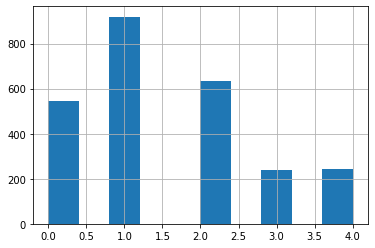

In [627]:
df['Type'].hist()

In [628]:
df.Type.value_counts()

1.0    919
2.0    632
0.0    543
4.0    245
3.0    238
Name: Type, dtype: int64

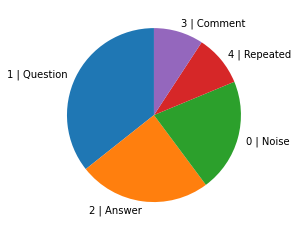

In [629]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(df.Type.value_counts())
mylabels = ["1 | Question","2 | Answer","0 | Noise", "4 | Repeated", "3 | Comment"]

plt.pie(y,  labels=mylabels,startangle = 90)
#plt.legend()
plt.show()

count number of emojies in each tweet and store it in a new column 

In [630]:
df['emoji']=df['Tweet'].apply(emoji_count)

In [631]:
df['emoji'].value_counts()

0     2132
1      131
4       97
2       94
10      31
6       25
3       25
9       21
5        8
8        5
7        5
12       2
16       2
Name: emoji, dtype: int64

see distrubtion of tweets types having one emoji at most

In [632]:
tweets_without_emoji=df.loc[df['emoji']<2]
tweets_without_emoji['Type'].value_counts()

1.0    917
2.0    631
0.0    344
3.0    232
4.0    139
Name: Type, dtype: int64

([<matplotlib.axis.XTick at 0x7fca5e057190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

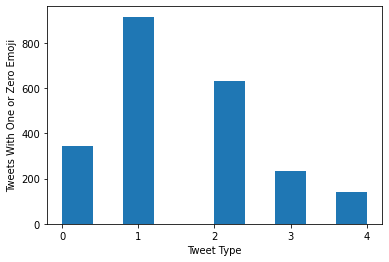

In [633]:
plt.hist(tweets_without_emoji['Type'])
plt.xlabel('Tweet Type')
plt.ylabel('Tweets With One or Zero Emoji')
plt.xticks([0,1,2,3,4])

see distrubtion of tweets types having 2 emojies or more

In [634]:
tweets_with_emoji=df.loc[df['emoji']>1]
tweets_with_emoji['Type'].value_counts()

0.0    199
4.0    106
3.0      6
1.0      2
2.0      1
Name: Type, dtype: int64

([<matplotlib.axis.XTick at 0x7fca5fbc7c40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

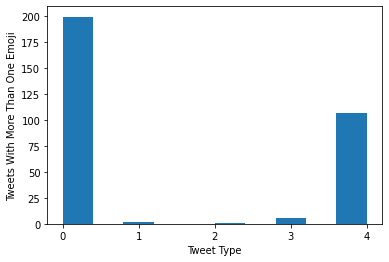

In [635]:
plt.hist(tweets_with_emoji['Type'])
plt.xlabel('Tweet Type')
plt.ylabel('Tweets With More Than One Emoji')
plt.xticks([0,1,2,3,4])

### most tweets that have emojis are of category = 1 which is 'noise' so the information of emoji is helpful in classification thus should not be removed, instead we will put the word explaining them

start executing helper functions on tweets to clean them

In [708]:
df['Cleaned_Tweet']=df['Tweet'].apply(remove_numbers_and_latin_chars)

In [709]:
df['Cleaned_Tweet']=df['Cleaned_Tweet'].apply(convert_emoji_to_text)

Now we will translate each english word that is result from emoji description to the word "ايموجي" 

In [710]:
df['Translated_Tweets']=df['Cleaned_Tweet'].apply(change_emoji_description)

In [711]:
df['Cleaned_Tweet_No_Stop_words']=df['Translated_Tweets'].apply(remove_stop_word)

In [712]:
df.head(2)

,Tweet,Type,emoji,Cleaned_Tweet,Translated_Tweets,Cleaned_Tweet_No_Stop_words,repeated
0,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,1.0,0,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,0
1,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,1.0,0,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,0


In below part, if a tweet is repeated(type=4), insert 1 in the 'repeated' column, else insert 0

In [713]:
df['repeated']=df['Type'].apply(count_repeated)
df.head(2)

,Tweet,Type,emoji,Cleaned_Tweet,Translated_Tweets,Cleaned_Tweet_No_Stop_words,repeated
0,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,1.0,0,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,السلام عليكم لدي عامل انتهي جواز السفر وتم تجد...,0
1,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,1.0,0,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,سلام عليكم عندي اضافه مولود ولما ادخل ابشر واض...,0


remove NANs

In [714]:
df.Cleaned_Tweet_No_Stop_words.dropna(inplace=True)

In [715]:
df.Type.dropna(inplace=True)

In [730]:
df.Type.isnull()
df= df.drop(df.index[186])

In [735]:
df= df.drop(df.index[1254])

In [750]:
#Split the data into X and y data sets
X = df['Cleaned_Tweet_No_Stop_words']
y = df.Type

In [751]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [754]:
#Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer()
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

Index(['ؤتوه', 'اب', 'ابابا', 'ابحث', 'ابد', 'ابدا', 'ابريل', 'ابشر',
       'ابشرالتوظيف', 'ابشربعز',
       ...
       'يوما', 'يوماجتياحالجنوب', 'يومان', 'يومك', 'يومنا', 'يومولم', 'يومي',
       'يومين', 'ٱبشر', 'ٱرجو'],
      dtype='object', length=5316)

### Baseline model using Logistic Regression

In [768]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [769]:
# Train the first model
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1 = lr.predict(X_test_tfidf1)

In [775]:
#Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred_tfidf1, digits=3))

              precision    recall  f1-score   support

         0.0      0.758     0.728     0.743       125
         1.0      0.733     0.958     0.830       166
         2.0      0.951     0.906     0.928       128
         3.0      0.455     0.222     0.299        45
         4.0      0.629     0.423     0.506        52

    accuracy                          0.771       516
   macro avg      0.705     0.647     0.661       516
weighted avg      0.758     0.771     0.754       516



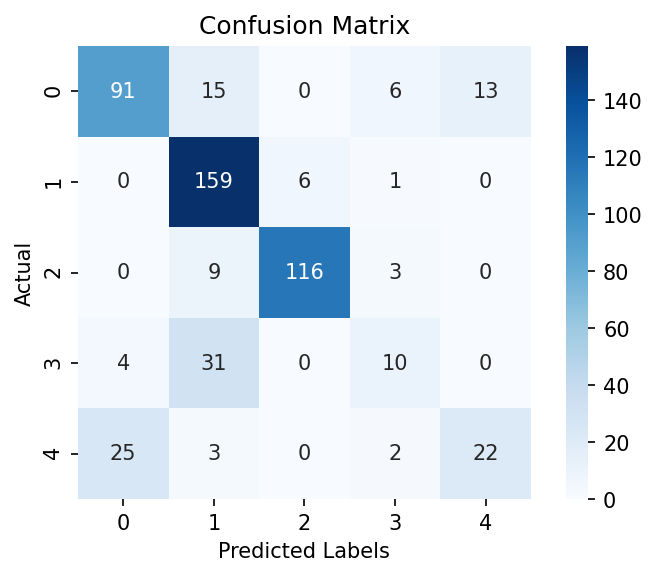

In [790]:
show_confusion_matrix(y_test,y_pred_tfidf1)

## Dimensionality Reducion using SVD

In [825]:
svd = TruncatedSVD(n_iter=30, n_components=100)
#Reduce the dimensions of data from 5000 to 100
x_train_SVD = svd.fit_transform(X_train_tfidf1)
x_test_SVD = svd.fit_transform(X_test_tfidf1)

In [826]:
# Train the first model
lr.fit(x_train_SVD, y_train)
y_pred_tfidf1_SVD = lr.predict(x_test_SVD)

In [827]:
#Print the precision and recall, among other metrics
print(metrics.classification_report(y_test,y_pred_tfidf1_SVD, digits=3))

              precision    recall  f1-score   support

         0.0      0.522     0.280     0.365       125
         1.0      0.547     0.699     0.614       166
         2.0      0.468     0.797     0.590       128
         3.0      0.111     0.044     0.063        45
         4.0      0.000     0.000     0.000        52

    accuracy                          0.494       516
   macro avg      0.330     0.364     0.326       516
weighted avg      0.428     0.494     0.438       516



In [200]:
# what are the  most common words in each category?

In [126]:
#SPacy (most common words in each category) OR TF-IDF

In [9]:
#unique words

In [ ]:
#adding scrapped more data

In [5]:
#CoreEX

In [6]:
#Topic Modeling